In [19]:
%matplotlib inline

import os
import matplotlib.pylab as plt
import numpy as np
from sc_fingerprint import *
from matplotlib import rc
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=False)

In [20]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor,
                     edgecolor='None', alpha=0.05, cmap=cm.winter,
                     pointsize=2):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    norm = mpl.colors.Normalize(vmin=np.min(facecolor), vmax=np.max(facecolor))
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, alpha=alpha, facecolor=m.to_rgba(facecolor))

    # Add collection to axes
    a = ax.add_collection(pc)

    # Plot errorbars
    sc = ax.scatter(xdata, ydata, s=pointsize, c=m.to_rgba(facecolor), alpha=1)
    
    return sc

## Load data

In [29]:
# load droplet-counts and chimera-counts
root = '/home/jupyter/data/10x/out/'
original_dataset_name = 'pbmc4k'
downsampled_dataset_name = 'pbmc4k_ss_rate_0.25'

# original_suffix = 'alpha_0.0__beta_0.5__default_gene_filters__rc'
# downsampled_suffix = 'alpha_0.0__beta_0.5__default_gene_filters__rc'

original_suffix = 'alpha_0.0__beta_0.5__default_gene_filters__rc_poisson_proper'
downsampled_suffix = 'alpha_0.0__beta_0.5__default_gene_filters__rc_poisson_proper'

# original_suffix = 'alpha_0.0__beta_0.5__expr_small_ladder_test__poisson_proper'
# downsampled_suffix = 'alpha_0.0__beta_0.5__expr_small_ladder_test__poisson_proper'

original_output_root = os.path.join(root, original_dataset_name + '__' + original_suffix)
downsampled_output_root = os.path.join(root, downsampled_dataset_name + '__' + downsampled_suffix)



# mutual genes between the two count matrices
enable_default_filters = False
original_gene_idx_list = np.load(os.path.join(original_output_root, 'gene_indices.npy'))
downsampled_gene_idx_list = np.load(os.path.join(downsampled_output_root, 'gene_indices.npy'))

if enable_default_filters:
    sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'
    sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path).filter_genes()
    passing_gene_idx_set = set(sc_fingerprint.gene_idx_list)
else:
    passing_gene_idx_set = set(original_gene_idx_list).union(set(downsampled_gene_idx_list))

mutual_gene_idx_set = set(original_gene_idx_list).intersection(set(downsampled_gene_idx_list)).intersection(passing_gene_idx_set)
mutual_gene_idx_list = [gene_index for gene_index in original_gene_idx_list
                        if gene_index in mutual_gene_idx_set]

original_gene_idx_dict = {
    gene_index: order for order, gene_index in enumerate(original_gene_idx_list)}
original_gene_idx_lookup = [
    original_gene_idx_dict[gene_index] for gene_index in mutual_gene_idx_list]

downsampled_gene_idx_dict = {
    gene_index: order for order, gene_index in enumerate(downsampled_gene_idx_list)}
downsampled_gene_idx_lookup = [
    downsampled_gene_idx_dict[gene_index] for gene_index in mutual_gene_idx_list]


# load inferred counts
original_e_hi_map = np.load(os.path.join(original_output_root, 'e_hi_map.npy'))
original_e_hi_map = np.sum(original_e_hi_map[:, original_gene_idx_lookup], axis=0)
original_e_hi_var = np.load(os.path.join(original_output_root, 'e_hi_var.npy'))
original_e_hi_var = np.sum(original_e_hi_var[:, original_gene_idx_lookup], axis=0)
original_e_hi_std = np.sqrt(original_e_hi_var)
original_e_hi_ci_upper = original_e_hi_map + original_e_hi_std
original_e_hi_ci_lower = np.maximum(original_e_hi_map - original_e_hi_std, 0)

downsampled_e_hi_map = np.load(os.path.join(downsampled_output_root, 'e_hi_map.npy'))
downsampled_e_hi_map = np.sum(downsampled_e_hi_map[:, downsampled_gene_idx_lookup], axis=0)
downsampled_e_hi_var = np.load(os.path.join(original_output_root, 'e_hi_var.npy'))
downsampled_e_hi_var = np.sum(downsampled_e_hi_var[:, downsampled_gene_idx_lookup], axis=0)
downsampled_e_hi_std = np.sqrt(downsampled_e_hi_var)
downsampled_e_hi_ci_upper = downsampled_e_hi_map + downsampled_e_hi_std
downsampled_e_hi_ci_lower = np.maximum(downsampled_e_hi_map - downsampled_e_hi_std, 0)

In [30]:
# load fingerprint (downsampled)
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
sc_fingerprint_datastore = SingleCellFingerprintDataStore(
    sc_fingerprint, gene_idx_list=mutual_gene_idx_list)
downsampled_raw_counts = np.sum(sc_fingerprint_datastore.obs_expr_matrix, axis=0)

# load fingerprint (original)
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
sc_fingerprint_datastore = SingleCellFingerprintDataStore(
    sc_fingerprint, gene_idx_list=mutual_gene_idx_list)
original_raw_counts = np.sum(sc_fingerprint_datastore.obs_expr_matrix, axis=0)

Some genes in the provided fingerprint have zero expression in the experiment!
Some genes in the provided fingerprint have zero expression in the experiment!


### Total gene expression

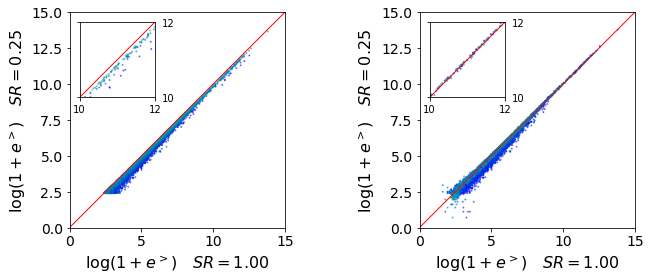

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
cmap = plt.cm.winter
alpha = 0.5
markersize = 1
_min, _max = np.min(downsampled_raw_counts), np.max(original_raw_counts)

ax = axs[0]
axins = inset_axes(ax, width="35%", height="35%", loc=2, borderpad=1)
for a in [ax, axins]:
    a.scatter(np.log1p(original_raw_counts), np.log1p(downsampled_raw_counts),
              c=sc_fingerprint_datastore.empirical_fsd_mu_hi,
              s=markersize, alpha=alpha, cmap=cmap)
ax.plot([0, _max], [0, _max], '-', color='red', lw=1)
ax.set_xlim((0, 15))
ax.set_ylim((0, 15))
ax.set_xlabel(r'$\log(1+e^>)\quad SR=1.00$', fontsize=16)
ax.set_ylabel(r'$\log(1+e^>)\quad SR=0.25$', fontsize=16)
ax.set_aspect('equal')

axins.plot([0, _max], [0, _max], '-', color='red', lw=1)
axins.set_xlim((10, 12))
axins.set_ylim((10, 12))
ticks = [10, 12]
axins.set_xticks(ticks)
axins.set_yticks(ticks)
axins.set_xticklabels(ticks, fontsize=10)
axins.set_yticklabels(ticks, fontsize=10)
axins.tick_params(labelleft=False, labelright=True, labelbottom=True)




ax = axs[1]
axins = inset_axes(ax, width="35%", height="35%", loc=2, borderpad=1)

for a in [ax, axins]:
    a.scatter(np.log1p(original_e_hi_map), np.log1p(downsampled_e_hi_map),
              c=sc_fingerprint_datastore.empirical_fsd_mu_hi,
              s=markersize, alpha=alpha, cmap=cmap)

# sc = make_error_boxes(
#     ax,
#     np.log1p(original_e_hi_map),
#     np.log1p(downsampled_e_hi_map),
#     3 * np.vstack((np.log1p(original_e_hi_map) - np.log1p(original_e_hi_ci_lower),
#                    np.log1p(original_e_hi_ci_upper) - np.log1p(original_e_hi_map))),
#     3 * np.vstack((np.log1p(downsampled_e_hi_map) - np.log1p(downsampled_e_hi_ci_lower),
#                    np.log1p(downsampled_e_hi_ci_upper) - np.log1p(downsampled_e_hi_map))),
#     sc_fingerprint_datastore.empirical_fsd_mu_hi,
#     alpha=0.3, pointsize=markersize)

# _ = make_error_boxes(
#     axins,
#     np.log1p(original_e_hi_map),
#     np.log1p(downsampled_e_hi_map),
#     3 * np.vstack((np.log1p(original_e_hi_map) - np.log1p(original_e_hi_ci_lower),
#                    np.log1p(original_e_hi_ci_upper) - np.log1p(original_e_hi_map))),
#     3 * np.vstack((np.log1p(downsampled_e_hi_map) - np.log1p(downsampled_e_hi_ci_lower),
#                    np.log1p(downsampled_e_hi_ci_upper) - np.log1p(downsampled_e_hi_map))),
#     sc_fingerprint_datastore.empirical_fsd_mu_hi,
#     alpha=0.3, pointsize=markersize)

axins.plot([0, _max], [0, _max], '-', color='red', lw=1)
axins.set_xlim((10, 12))
axins.set_ylim((10, 12))
ticks = [10, 12]
axins.set_xticks(ticks)
axins.set_yticks(ticks)
axins.set_xticklabels(ticks, fontsize=10)
axins.set_yticklabels(ticks, fontsize=10)
axins.tick_params(labelleft=False, labelright=True, labelbottom=True)


# cbar = plt.colorbar(sc)
# cbar.set_label(r'$\mu^>_\mathrm{emp.}$')

ax.plot([0, _max], [0, _max], '-', color='red', lw=1)
ax.set_xlim((0, 15))
ax.set_ylim((0, 15))
ax.set_xlabel(r'$\log(1+e^>)\quad SR=1.00$', fontsize=16)
ax.set_ylabel(r'$\log(1+e^>)\quad SR=0.25$', fontsize=16)
ax.set_aspect('equal')

plt.tight_layout()

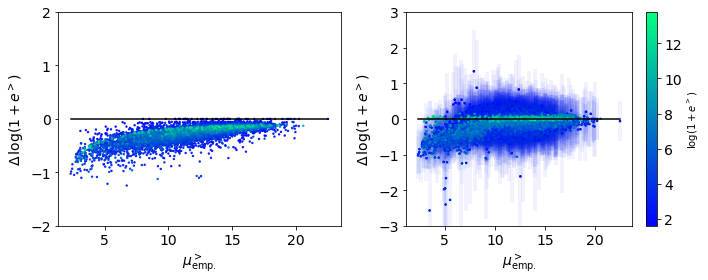

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
cmap = plt.cm.winter
alpha = 0.9
markersize = 2

ax = axs[0]
delta_mean = np.log1p(downsampled_raw_counts) - np.log1p(original_raw_counts)
sc = ax.scatter(sc_fingerprint_datastore.empirical_fsd_mu_hi[::-1],
                delta_mean[::-1],
                c=np.log1p(original_raw_counts)[::-1],
                s=markersize, alpha=alpha, cmap=cmap)

ax.set_ylim((-2, 2))
_min, _max = (np.min(sc_fingerprint_datastore.empirical_fsd_mu_hi), 
              np.max(sc_fingerprint_datastore.empirical_fsd_mu_hi))
ax.plot([_min, _max], [0.0, 0.0], '-', color='black', alpha=1)
ax.set_ylabel(r'$\Delta\,\log(1+e^>)$', fontsize=14)
ax.set_xlabel(r'$\mu^>_\mathrm{emp.}$', fontsize=14)

ax = axs[1]
delta_mean = np.log1p(downsampled_e_hi_map) - np.log1p(original_e_hi_map)
delta_var = (downsampled_e_hi_var / np.power(1 + downsampled_e_hi_map, 2) +
             original_e_hi_var / np.power(1 + original_e_hi_map, 2))
delta_std = np.sqrt(delta_var)

sc = ax.scatter(sc_fingerprint_datastore.empirical_fsd_mu_hi[::-1],
                delta_mean[::-1],
                c=np.log1p(original_e_hi_map)[::-1],
                s=markersize, alpha=alpha, cmap=cmap)

n_genes = sc_fingerprint_datastore.empirical_fsd_mu_hi.size
make_error_boxes(
    ax,
    sc_fingerprint_datastore.empirical_fsd_mu_hi[::-1],
    delta_mean[::-1],
    0.2 * np.ones((2, n_genes)),
    2 * np.vstack((delta_std[::-1], delta_std[::-1])),
    np.log1p(original_e_hi_map)[::-1],
    alpha=0.05, pointsize=markersize)


ax.set_ylim((-3, 3))
_min, _max = (np.min(sc_fingerprint_datastore.empirical_fsd_mu_hi), 
              np.max(sc_fingerprint_datastore.empirical_fsd_mu_hi))
ax.plot([_min, _max], [0.0, 0.0], '-', color='black', alpha=1)
ax.set_ylabel(r'$\Delta\,\log(1+e^>)$', fontsize=14)
ax.set_xlabel(r'$\mu^>_\mathrm{emp.}$', fontsize=14)

cbar = plt.colorbar(sc)
cbar.set_label(r'$\log(1 + e^>)$')

plt.tight_layout()

In [33]:
diff_ratio = downsampled_e_hi_map/original_e_hi_map - 1.

In [34]:
sorted(list(enumerate(diff_ratio)), key=lambda item: np.abs(item[1]), reverse=True)

[(10803, 3.5),
 (12577, 1.75),
 (10652, 1.5),
 (11839, -0.96),
 (11405, -0.9375),
 (11669, -0.9285714285714286),
 (12128, -0.9),
 (11455, -0.8888888888888888),
 (10919, -0.8809523809523809),
 (12270, -0.85),
 (11620, 0.8333333333333333),
 (12137, 0.8333333333333333),
 (11747, -0.7391304347826086),
 (12316, -0.736842105263158),
 (12766, -0.7272727272727273),
 (10194, -0.7241379310344828),
 (10686, -0.7173913043478262),
 (12759, 0.7142857142857142),
 (11379, -0.6875),
 (2211, -0.6772673733804475),
 (9862, -0.6716417910447761),
 (8977, -0.6666666666666667),
 (11161, -0.6666666666666667),
 (11849, 0.6666666666666667),
 (12167, -0.6666666666666667),
 (12570, 0.6666666666666667),
 (11399, -0.65625),
 (3307, -0.6552346570397112),
 (10551, -0.653061224489796),
 (11433, -0.6451612903225806),
 (10799, -0.6363636363636364),
 (9422, -0.6352941176470588),
 (7744, -0.6326530612244898),
 (11047, -0.631578947368421),
 (11762, -0.6296296296296297),
 (3337, -0.6265938069216758),
 (11858, 0.625),
 (11968